In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
import sys
sys.path.append('../src')

from data_collection import FinancialDataCollector
from visualization_utils import VisualizationUtils
from config import COLOR_PALETTE

In [4]:
# Load data
collector = FinancialDataCollector()
stock_data = collector.load_stock_data()
master_df = pd.read_csv('./data/processed/master_prices.csv', index_col=0, parse_dates=True)


Data loaded from data\raw\stock_data.pkl


In [5]:
# Setup visualization utilities
viz_utils = VisualizationUtils()
viz_utils.setup_plot_style()

Plot saved to static/images\matplotlib_stock_prices.png


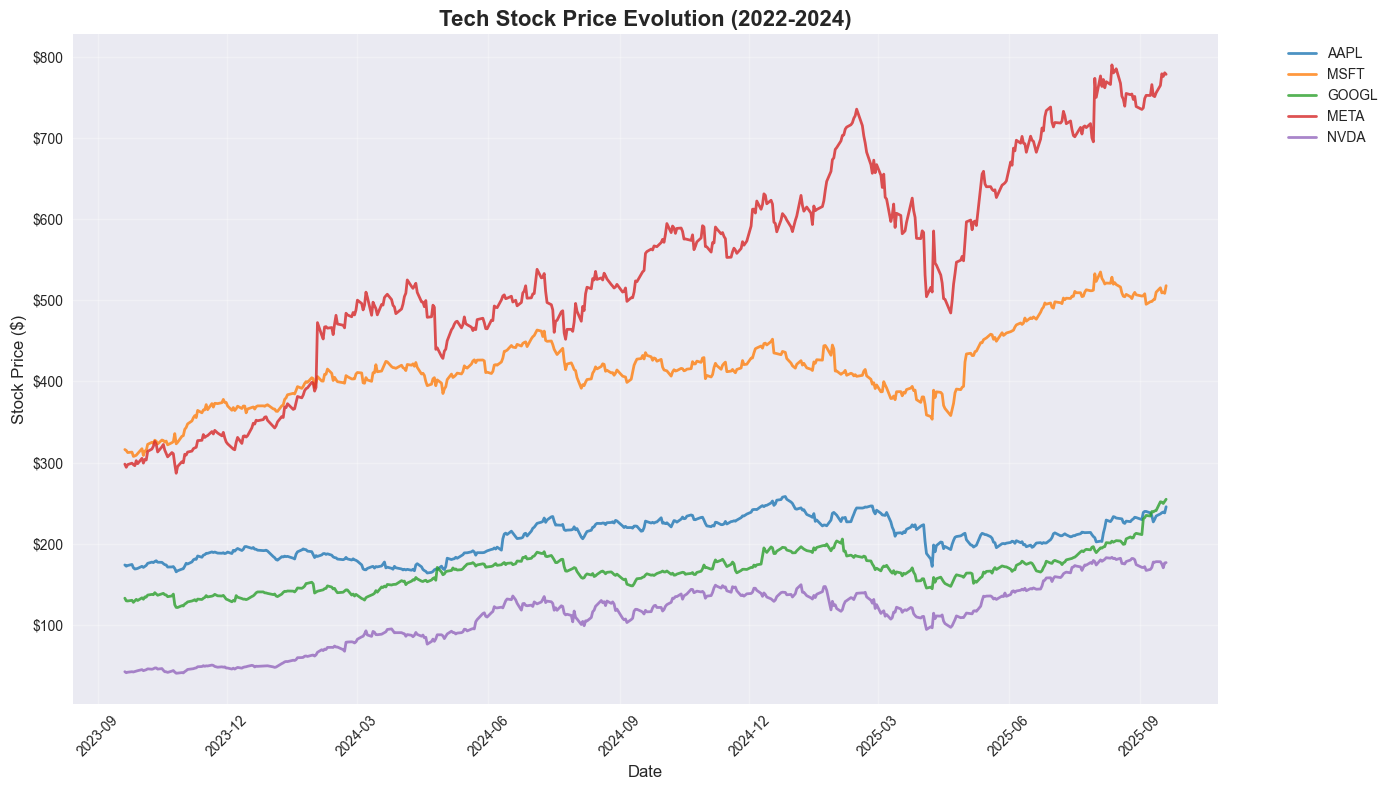

In [ ]:
# PLOT-1: Basic Stock Price Line Plot
def create_stock_price_plot():
    fig, ax = plt.subplots(figsize=(14, 8))
    
    tech_stocks = ['AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA']         # Plot top 5 tech stocks
    
    for stock in tech_stocks:
        if stock in master_df.columns:
            ax.plot(master_df.index, master_df[stock], 
                   label=stock, linewidth=2, alpha=0.8)
    
    ax.set_title('Tech Stock Price Evolution (2022-2024)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Stock Price ($)', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    viz_utils.format_currency_axis(ax, 'y')                             # Format y-axis as currency
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))         # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    viz_utils.save_plot(fig, 'matplotlib_stock_prices.png')
    plt.show()

create_stock_price_plot()

Plot saved to static/images\matplotlib_candlestick_AAPL.png


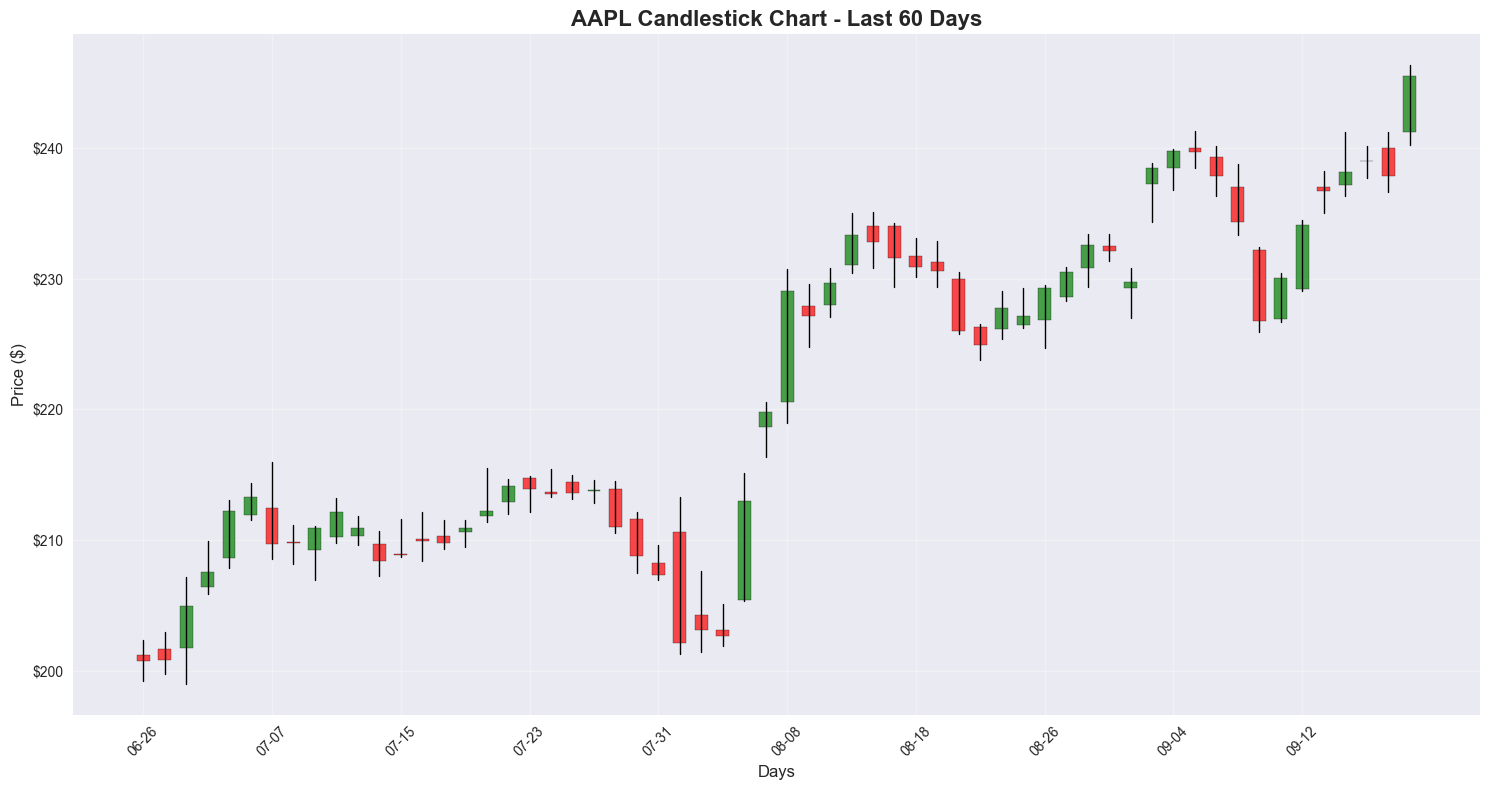

In [ ]:
# PLOT-2: Candlestick Chart
def create_candlestick_chart(ticker='AAPL', days=60):
    from matplotlib.patches import Rectangle
    
    stock_prices = stock_data[ticker]['prices'].tail(days)          # Get recent data
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    for idx, (date, row) in enumerate(stock_prices.iterrows()):     # Create candlestick chart
        open_price = row['Open']
        high_price = row['High'] 
        low_price = row['Low']
        close_price = row['Close']
        
        color = 'green' if close_price >= open_price else 'red'     # Determine color
        
        ax.plot([idx, idx], [low_price, high_price], color='black', linewidth=1)        # Draw high-low line
        
        height = abs(close_price - open_price)                      # Draw open-close rectangle
        bottom = min(open_price, close_price)
        rect = Rectangle((idx-0.3, bottom), 0.6, height, 
                        facecolor=color, alpha=0.7, edgecolor='black')
        ax.add_patch(rect)
    
    ax.set_title(f'{ticker} Candlestick Chart - Last {days} Days', fontsize=16, fontweight='bold')
    ax.set_xlabel('Days', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    step = max(1, days // 10)                               # Set x-axis labels
    ax.set_xticks(range(0, len(stock_prices), step))
    ax.set_xticklabels([date.strftime('%m-%d') for date in stock_prices.index[::step]], rotation=45)
    
    viz_utils.format_currency_axis(ax, 'y')
    
    plt.tight_layout()
    viz_utils.save_plot(fig, f'matplotlib_candlestick_{ticker}.png')
    plt.show()

create_candlestick_chart('AAPL', 60)

Plot saved to static/images\matplotlib_volume_analysis_AAPL.png


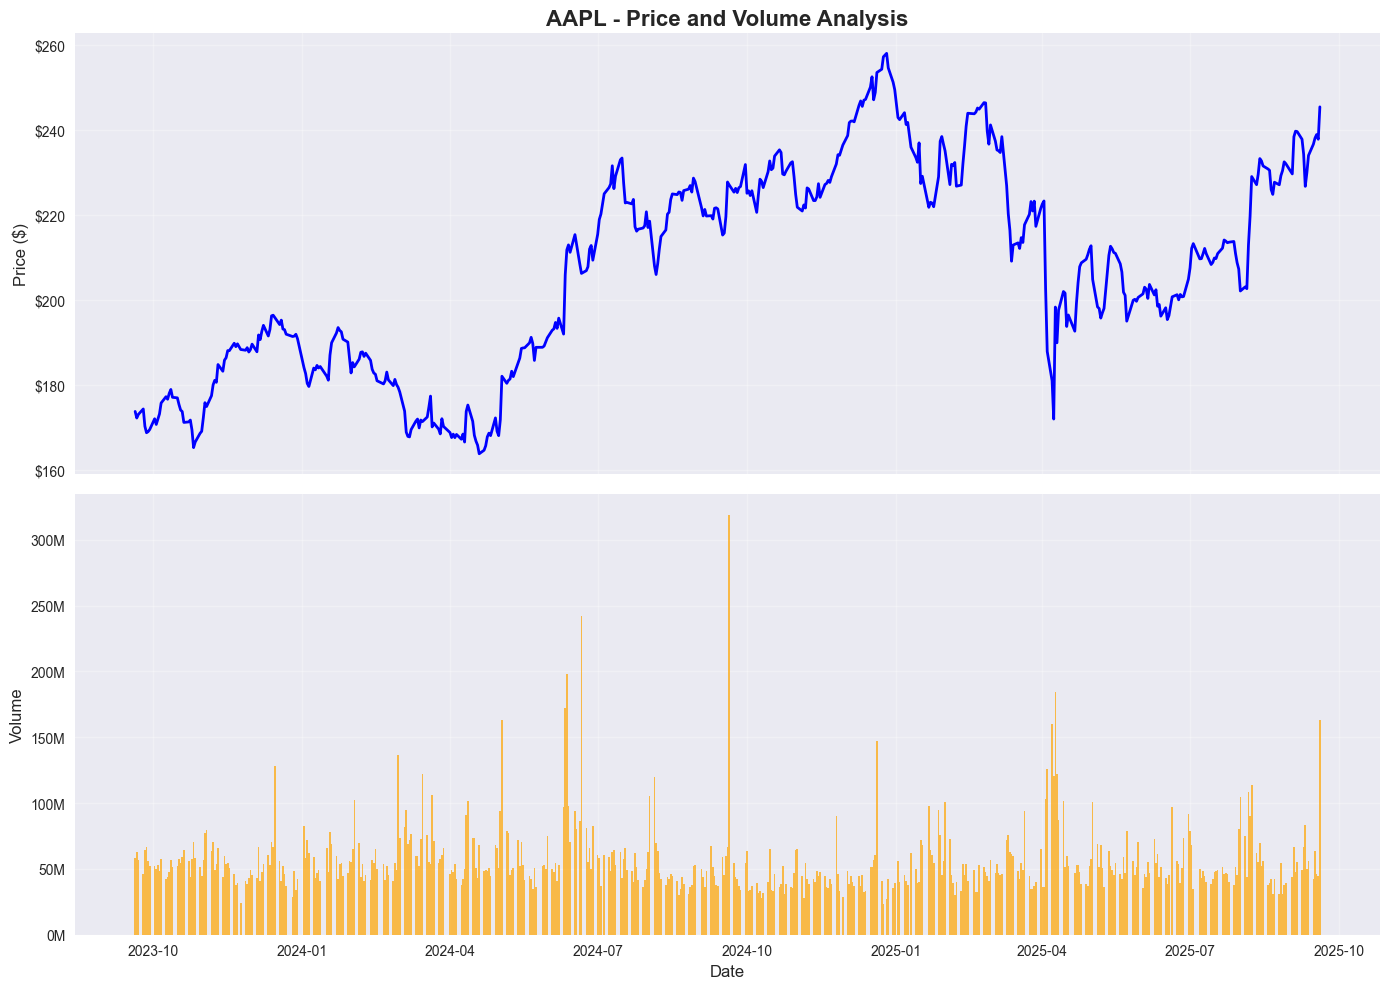

In [9]:
# Plot-3: Volume Analysis
def create_volume_analysis():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    ticker = 'AAPL'
    stock_prices = stock_data[ticker]['prices']
    
    ax1.plot(stock_prices.index, stock_prices['Close'], color='blue', linewidth=2)              # Price plot
    ax1.set_title(f'{ticker} - Price and Volume Analysis', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    viz_utils.format_currency_axis(ax1, 'y')
    
    ax2.bar(stock_prices.index, stock_prices['Volume'],             # Volume plot
           color='orange', alpha=0.7, width=1)
    ax2.set_ylabel('Volume', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))      # Format volume axis
    
    plt.tight_layout()
    viz_utils.save_plot(fig, f'matplotlib_volume_analysis_{ticker}.png')
    plt.show()

create_volume_analysis()

Plot saved to static/images\matplotlib_returns_distribution.png


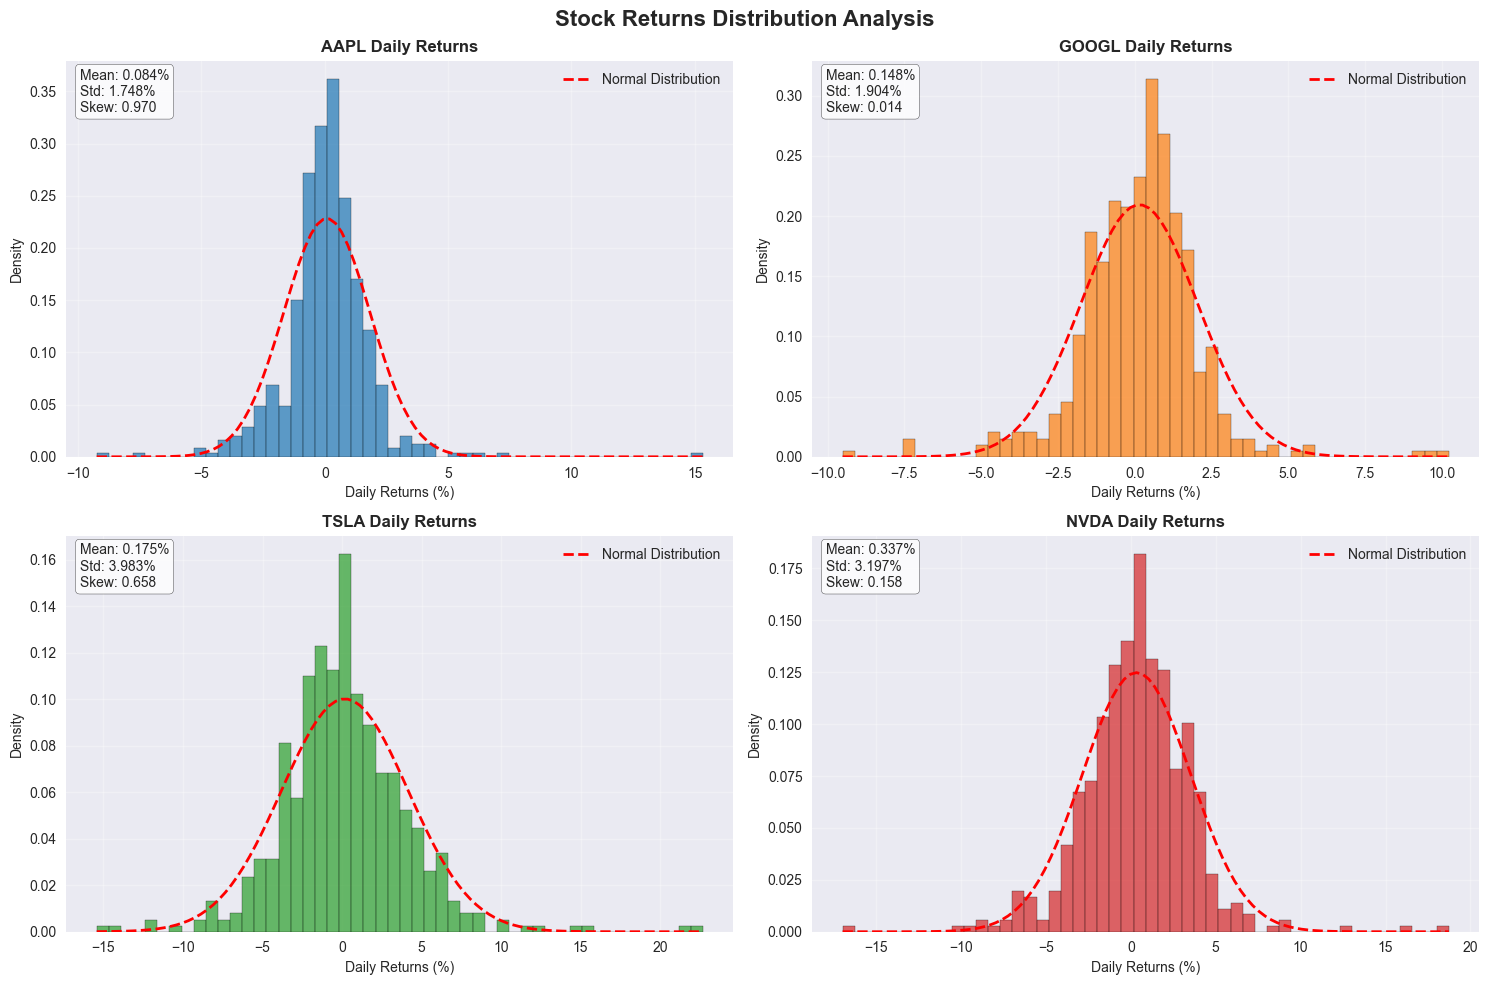

In [13]:
# Plot-4: Returns Distribution
def create_returns_distribution():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Stock Returns Distribution Analysis', fontsize=16, fontweight='bold')
    
    stocks = ['AAPL', 'GOOGL', 'TSLA', 'NVDA']
    
    for idx, ticker in enumerate(stocks):
        row, col = idx // 2, idx % 2
        ax = axes[row, col]
        
        returns = stock_data[ticker]['prices']['Returns'].dropna() * 100
        
        ax.hist(returns, bins=50, alpha=0.7, color=COLOR_PALETTE[idx],          # Histogram
               density=True, edgecolor='black')
        
        mu, sigma = returns.mean(), returns.std()                               # Add normal distribution overlay
        x = np.linspace(returns.min(), returns.max(), 100)
        normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        ax.plot(x, normal_dist, 'r--', linewidth=2, label='Normal Distribution')
        
        ax.set_title(f'{ticker} Daily Returns', fontsize=12, fontweight='bold')
        ax.set_xlabel('Daily Returns (%)', fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        stats_text = f'Mean: {mu:.3f}%\nStd: {sigma:.3f}%\nSkew: {returns.skew():.3f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    viz_utils.save_plot(fig, 'matplotlib_returns_distribution.png')
    plt.show()

create_returns_distribution()

Plot saved to static/images\matplotlib_moving_averages_AAPL.png


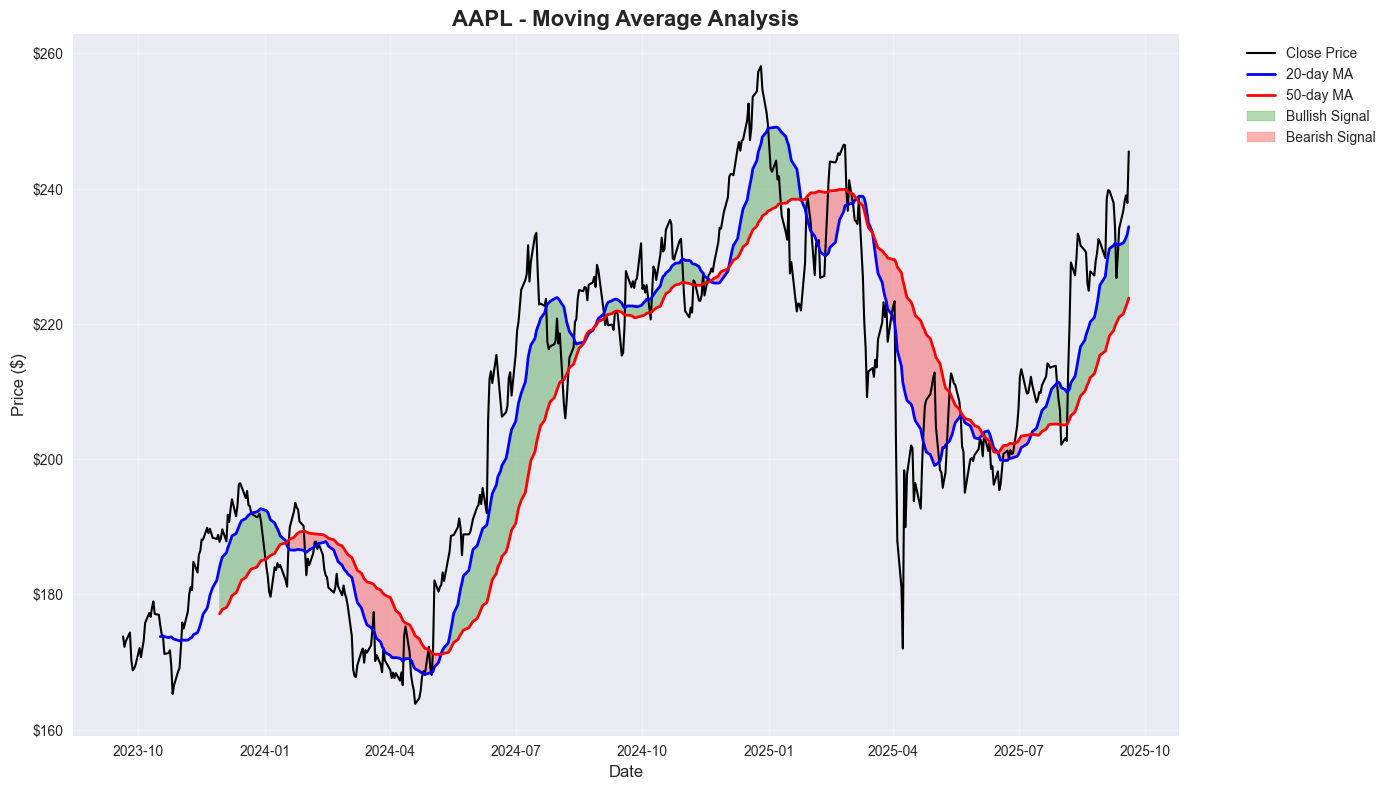

In [15]:
# Plot-5. Moving Averages Comparison
def create_moving_averages_plot():
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ticker = 'AAPL'
    prices = stock_data[ticker]['prices']
    
    ax.plot(prices.index, prices['Close'], label='Close Price', color='black', linewidth=1.5)       # Plot price and moving averages
    ax.plot(prices.index, prices['MA_20'], label='20-day MA', color='blue', linewidth=2)
    ax.plot(prices.index, prices['MA_50'], label='50-day MA', color='red', linewidth=2)
    
    ax.fill_between(prices.index, prices['MA_20'], prices['MA_50'],                     # Fill between moving averages
                   where=(prices['MA_20'] >= prices['MA_50']), 
                   color='green', alpha=0.3, label='Bullish Signal')
    ax.fill_between(prices.index, prices['MA_20'], prices['MA_50'],
                   where=(prices['MA_20'] < prices['MA_50']), 
                   color='red', alpha=0.3, label='Bearish Signal')
    
    ax.set_title(f'{ticker} - Moving Average Analysis', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    viz_utils.format_currency_axis(ax, 'y')
    
    plt.tight_layout()
    viz_utils.save_plot(fig, f'matplotlib_moving_averages_{ticker}.png')
    plt.show()

create_moving_averages_plot()